In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

# Necessary

- Create VE
- Create dataset

In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs

import torch
import torch.nn as nn
import random
import time
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import ast

print(torch.__version__)

2.5.0+cu121


In [8]:
# Configuration / hyperparameters
config = {
    "NUM_EPOCHS": 200,       # Total Epochs in training
    "EVAL_EPOCH_FREQ": 20,   # Evaluation frequency
    "BATCH_SIZE": 32,       # Batch size
    "LR": 5e-4,             # Learning rate
    "LR_DECAY_GAMMA": 0.5,    # Learning rate decay
    "LR_DECAY_STEPS_EPOCHS": 50, # Learning rate decay steps
    "SEED": 42,             # Random seed
    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t6_8M_UR50D", # ESM2 model name
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DATASET_PATH": "/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/only-guaranteed_cell-cycle-dataset_2:3.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv", 
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)
    "PATH_TO_SAVE_MODEL": "/home/gdallagl/myworkdir/ESMSec/data/trained_models/cell_cycle_trained_model.pth", # Path to save the model
    "TYPE_HEAD":"LR",# "attention", #"MLP",
    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",
    "FROM_PRECOMPUTED_EMBS": True,
}
config["PRECOMPUTED_EMBS_PATH"] = (
    f"{config['DATASET_PATH'].split('.')[0]}_embs_"
    f"{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.csv"
)

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Instantiate ESM model

In [4]:
# Load pre-trained ESM model
esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"]).to(config["DEVICE"])
# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



# Load Dataset

 19%|█▊        | 30/161 [00:00<00:00, 297.82it/s]

100%|██████████| 161/161 [00:00<00:00, 289.91it/s]


<Axes: >

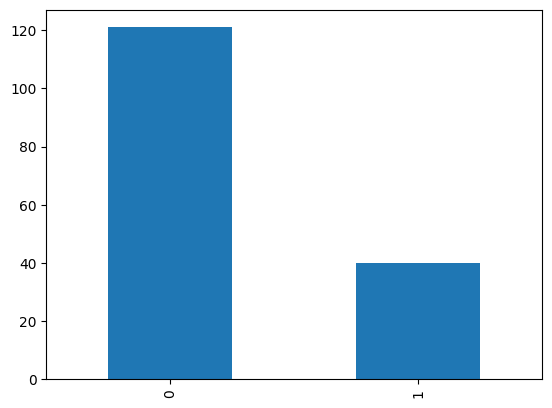

In [ ]:
# Load dataset
data = pd.read_csv(config["DATASET_PATH"])

# Preprocess each sequence individually
preprocessed_data = []
for idx, row in tqdm(data.iterrows(), total=len(data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
processed_df = pd.DataFrame(preprocessed_data)

# Add the 'set' column back from original data
processed_df['set'] = data['set'].values
processed_df['embedding'] = [[] for _ in range(len(processed_df))] #data['embedding'].values

processed_df.head(5)

processed_df["label"].value_counts().reset_index(drop="True").plot(kind='bar')

# Add or Create embs

Only if "from_precomputed_embs" is True

In [9]:
# add or use preocmputed embs only if needed
if config["FROM_PRECOMPUTED_EMBS"]:

    # if csv with embes exixst just load it
    if os.path.exists(config["PRECOMPUTED_EMBS_PATH"]):
        embs_df = pd.read_csv(config["PRECOMPUTED_EMBS_PATH"])

    # else make ebs
    else:
        
        embs_df = pd.DataFrame(columns=["protein", "embedding"])

        for idx, row in tqdm(processed_df.iterrows(), total=len(processed_df), desc="Processing proteins"):

            # needs to be [batch_size, len]
            input_ids = row["input_ids"].clone().detach().unsqueeze(0).to(config["DEVICE"])
            attention_mask = row["attention_mask"].clone().detach().unsqueeze(0).to(config["DEVICE"])

            # taje emsn only of the ouput of the ESM model
                # ATTENTION: we need that seq are alredy TOKENIZED adn TRUNATED
            outputs_esm = esm_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

            if config["TYPE_EMB_FOR_CLASSIFICATION"] == "agg_mean":
                input_class_head = torch.mean(outputs_esm.last_hidden_state, dim=1)
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "agg_max":
                input_class_head, _ = torch.max(outputs_esm.last_hidden_state, dim=1)
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "cls":
                input_class_head = outputs_esm.last_hidden_state[:, 0, :] 
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "concat(agg_mean, agg_max)":
                mean_pool = torch.mean(outputs_esm.last_hidden_state, dim=1)
                max_pool, _ = torch.max(outputs_esm.last_hidden_state, dim=1)
                input_class_head = torch.cat((mean_pool, max_pool), dim=1) 
            elif config["TYPE_EMB_FOR_CLASSIFICATION"] == "concat(agg_mean, agg_max, cls)":
                mean_pool = torch.mean(outputs_esm.last_hidden_state, dim=1)
                max_pool, _ = torch.max(outputs_esm.last_hidden_state, dim=1)
                cls = outputs_esm.last_hidden_state[:, 0, :] 
                input_class_head = torch.cat((mean_pool, max_pool, cls), dim=1) 

            embs_df.loc[idx] = [row["protein"], input_class_head.squeeze(0).detach().cpu().numpy().tolist()]

        display(embs_df.head())

        embs_df.to_csv(config["PRECOMPUTED_EMBS_PATH"], index=False)

Processing proteins:   0%|          | 0/161 [00:00<?, ?it/s]

Processing proteins: 100%|██████████| 161/161 [00:02<00:00, 61.89it/s]


,protein,embedding
0,O95067,"[0.09188975393772125, 0.4755372107028961, 0.19..."
1,Q9H8V3,"[0.018093958497047424, 0.3849007189273834, 0.2..."
2,Q9NQW6,"[-0.060880593955516815, 0.4067435562610626, 0...."
3,P33552,"[0.2549079656600952, 0.604741632938385, 0.0234..."
4,Q9H967,"[-0.004934774246066809, 0.3582823872566223, 0...."


In [10]:
if config["FROM_PRECOMPUTED_EMBS"]:
    # add embs
    processed_df = pd.merge(how="left", left=processed_df, right=embs_df, on="protein", suffixes=("_tmp", ""))  # rename duplicates from right temporarily)

    # convert to torch tensoers
    processed_df['embedding'] = processed_df['embedding'].apply(
        lambda x: torch.tensor(x, dtype=torch.float32)
    )

    # xcheck for sampels with missing embs

    # sasve dim size
    config["PRECOMPUTED_EMBS_DIM"] = int(processed_df.loc[0, "embedding"].shape[0])

processed_df.head()

,sequence,trunc_sequence,input_ids,attention_mask,label,protein,sequence_length,trunc_sequence_length,inputs_ids_length,inputs_ids_length_no_pad,set,embedding_tmp,embedding
0,MALLRRPTVSSDLENIDTGVNSKVKSHVTIRRTVLEEIGNRVTTRA...,MALLRRPTVSSDLENIDTGVNSKVKSHVTIRRTVLEEIGNRVTTRA...,"[tensor(0), tensor(20), tensor(5), tensor(4), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,O95067,398,398,1000,400,train,[],"[tensor(0.0919), tensor(0.4755), tensor(0.1915..."
1,MAENSVLTSTTGRTSLADSSIFDSKVTEISKENLLIGSTSYVEEEM...,MAENSVLTSTTGRTSLADSSIFDSKVTEISKENLLIGSTSYVEEEM...,"[tensor(0), tensor(20), tensor(5), tensor(9), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,Q9H8V3,914,914,1000,916,train,[],"[tensor(0.0181), tensor(0.3849), tensor(0.2855..."
2,MDPFTEKLLERTRARRENLQRKMAERPTAAPRSMTHAKRARQPLSE...,MDPFTEKLLERTRARRENLQRKMAERPTAAPRSMTHAKRARQPLSE...,"[tensor(0), tensor(20), tensor(13), tensor(14)...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,Q9NQW6,1124,1000,1000,1000,train,[],"[tensor(-0.0609), tensor(0.4067), tensor(0.227..."
3,MAHKQIYYSDKYFDEHYEYRHVMLPRELSKQVPKTHLMSEEEWRRL...,MAHKQIYYSDKYFDEHYEYRHVMLPRELSKQVPKTHLMSEEEWRRL...,"[tensor(0), tensor(20), tensor(5), tensor(21),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,P33552,79,79,1000,81,train,[],"[tensor(0.2549), tensor(0.6047), tensor(0.0234..."
4,MSRSGAAAEKADSRQRPQMKVNEYKENQNIAYVSLRPAQTTVLIKT...,MSRSGAAAEKADSRQRPQMKVNEYKENQNIAYVSLRPAQTTVLIKT...,"[tensor(0), tensor(20), tensor(8), tensor(10),...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",1,Q9H967,626,626,1000,628,train,[],"[tensor(-0.0049), tensor(0.3583), tensor(0.345..."


# Create DataLoaders

In [11]:
# ATTENTION: the name of the cols in the df must be speicifc
train_dl = my_dataset.create_dataloader(processed_df, 'train', config["BATCH_SIZE"], shuffle=True)
valid_dl = my_dataset.create_dataloader(processed_df, 'val', config["BATCH_SIZE"], shuffle=False)
test_dl = my_dataset.create_dataloader(processed_df, 'test', config["BATCH_SIZE"], shuffle=False)

# little check:
for batch in train_dl:
    _, _, labels, _, _ = batch
    print(batch)
    print(labels.shape, labels.dtype, labels[:5])
    break

[tensor([[ 0, 20, 10,  ...,  1,  1,  1],
        [ 0, 20, 11,  ...,  1,  1,  1],
        [ 0, 20, 22,  ...,  1,  1,  1],
        ...,
        [ 0, 20, 14,  ...,  1,  1,  1],
        [ 0, 20,  9,  ..., 16,  7,  2],
        [ 0, 20,  5,  ...,  1,  1,  1]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0]), ['P68366', 'Q96LB4', 'Q96SM3', 'P30307', 'Q9NTI5', 'Q9GZU3', 'P14784', 'Q3MIV0', 'P54289', 'P34913', 'P17405', 'Q96M86', 'P63302', 'Q9H967', 'Q96IJ6', 'P13010', 'Q9NP78', 'A8K4G0', 'Q96PC2', 'P68363', 'Q9Y6I4', 'P20592', 'P41279', 'P49454', 'A0AVK6', 'O43663', 'Q9HAW4', 'Q8N9W6', 'Q96MR7', 'Q9NR45', 'Q86UP2', 'Q8N6Q8'], tensor([[ 0.3038,  0.5616,  0.0710,  ...,  0.7761, -0.0114, -0.2903],
        [ 0.0914,  

# Instantiate Full model

In [12]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"],
                           precomputed_embs_dim=config["PRECOMPUTED_EMBS_DIM"]
                           ).to(config["DEVICE"])
# hidden dim of final embeggin of each aa after trnafoerm 
print(net.class_head)

# Block ESM paramters to be trained
if net.esm_model is not None:
    print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
    for param in net.esm_model.parameters():
        param.requires_grad = False

LogisticRegressionHead(
  (classifier): Linear(in_features=320, out_features=2, bias=True)
)

ESM hidden dim 320 



# Define weighted loss fucntion

In [15]:
# Get class counts (ordered by label)
class_counts = processed_df[processed_df.set == "train"].label.value_counts().sort_index()
print("Class counts (ordered by label):", class_counts.to_dict())

# Convert counts to list [count_class_0, count_class_1]
class_counts_list = class_counts.tolist()

# Total number of samples
N = sum(class_counts_list)

# Compute class weights using w_i =  N / N_i
class_weights = torch.tensor([N / class_counts_list[0], N / class_counts_list[1]], dtype=torch.float)

# scale to avoid biased towrad class 1
#reduces bias toward class 1 while still giving minority class more importance.
class_weights = class_weights / class_weights.max()  # max weight = 1

# Move to device
class_weights = class_weights.to(config["DEVICE"])

# Print for sanity check
print(f"Class 0 count: {class_counts_list[0]}, weight: {class_weights[0]:.4f}")
print(f"Class 1 count: {class_counts_list[1]}, weight: {class_weights[1]:.4f}")

# Create loss function with class weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts (ordered by label): {0: 96, 1: 32}
Class 0 count: 96, weight: 0.3333
Class 1 count: 32, weight: 1.0000


# Train

In [18]:
#results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config)
results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config, from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]) # precomputed are in the dataloder

Training:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 2:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 3:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 4:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 5:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 6:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 7:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 8:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 9:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 10:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 11:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 12:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 13:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 14:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 15:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 16:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 17:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 18:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 19:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 20:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 20 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.4309, Acc: 80.47%, Balanced Acc: 82.81%, F1: 0.6914, MCC: 0.5846


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7176, Acc: 56.25%, Balanced Acc: 62.50%, F1: 0.4615, MCC: 0.2182


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.5198, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 21:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 22:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 23:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 24:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 25:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 26:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 27:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 28:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 29:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 30:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 31:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 32:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 33:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 34:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 35:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 36:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 37:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 38:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 39:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 40:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 40 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.4093, Acc: 84.38%, Balanced Acc: 85.42%, F1: 0.7368, MCC: 0.6458


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7242, Acc: 56.25%, Balanced Acc: 62.50%, F1: 0.4615, MCC: 0.2182


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.5075, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 41:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 42:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 43:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 44:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 45:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 46:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 47:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 48:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 49:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 50:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 51:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 52:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 53:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 54:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 55:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 56:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 57:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 58:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 59:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 60:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 60 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3969, Acc: 86.72%, Balanced Acc: 86.98%, F1: 0.7671, MCC: 0.6864


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7284, Acc: 62.50%, Balanced Acc: 66.67%, F1: 0.5000, MCC: 0.2887


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4994, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 61:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 62:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 63:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 64:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 65:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 66:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 67:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 68:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 69:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 70:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 71:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 72:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 73:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 74:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 75:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 76:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 77:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 78:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 79:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 80:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 80 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3897, Acc: 83.59%, Balanced Acc: 84.90%, F1: 0.7273, MCC: 0.6329


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7270, Acc: 56.25%, Balanced Acc: 62.50%, F1: 0.4615, MCC: 0.2182


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4983, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 81:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 82:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 83:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 84:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 85:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 86:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 87:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 88:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 89:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 90:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 91:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 92:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 93:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 94:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 95:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 96:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 97:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 98:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 99:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 100:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 100 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3846, Acc: 85.16%, Balanced Acc: 85.94%, F1: 0.7467, MCC: 0.6589


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7286, Acc: 62.50%, Balanced Acc: 66.67%, F1: 0.5000, MCC: 0.2887


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4942, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 101:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 102:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 103:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 104:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 105:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 106:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 107:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 108:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 109:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 110:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 111:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 112:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 113:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 114:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 115:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 116:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 117:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 118:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 119:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 120:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 120 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3793, Acc: 85.94%, Balanced Acc: 86.46%, F1: 0.7568, MCC: 0.6725


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7295, Acc: 62.50%, Balanced Acc: 66.67%, F1: 0.5000, MCC: 0.2887


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4922, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 121:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 122:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 123:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 124:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 125:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 126:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 127:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 128:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 129:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 130:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 131:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 132:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 133:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 134:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 135:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 136:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 137:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 138:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 139:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 140:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 140 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3736, Acc: 85.94%, Balanced Acc: 86.46%, F1: 0.7568, MCC: 0.6725


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7306, Acc: 62.50%, Balanced Acc: 66.67%, F1: 0.5000, MCC: 0.2887


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4898, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 141:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 142:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 143:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 144:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 145:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 146:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 147:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 148:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 149:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 150:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 151:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 152:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 153:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 154:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 155:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 156:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 157:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 158:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 159:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 160:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 160 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3738, Acc: 85.94%, Balanced Acc: 86.46%, F1: 0.7568, MCC: 0.6725


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7309, Acc: 62.50%, Balanced Acc: 66.67%, F1: 0.5000, MCC: 0.2887


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4887, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 161:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 162:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 163:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 164:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 165:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 166:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 167:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 168:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 169:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 170:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 171:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 172:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 173:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 174:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 175:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 176:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 177:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 178:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 179:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 180:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 180 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3712, Acc: 85.94%, Balanced Acc: 86.46%, F1: 0.7568, MCC: 0.6725


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7311, Acc: 62.50%, Balanced Acc: 66.67%, F1: 0.5000, MCC: 0.2887


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4879, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


Epoch 181:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 182:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 183:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 184:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 185:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 186:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 187:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 188:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 189:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 190:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 191:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 192:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 193:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 194:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 195:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 196:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 197:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 198:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 199:   0%|          | 0/4 [00:00<?, ?train batch/s]

Epoch 200:   0%|          | 0/4 [00:00<?, ?train batch/s]

--- Evaluation at iteration 200 ---


Evaluation:   0%|          | 0/4 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.3646, Acc: 85.94%, Balanced Acc: 86.46%, F1: 0.7568, MCC: 0.6725


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.7311, Acc: 62.50%, Balanced Acc: 66.67%, F1: 0.5000, MCC: 0.2887


Evaluation:   0%|          | 0/1 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.4873, Acc: 64.71%, Balanced Acc: 76.92%, F1: 0.5714, MCC: 0.4641


### Plot


                         FINAL EVALUATION METRICS
Metric                    Train      Validation            Test
--------------- --------------- --------------- ---------------
Loss                     0.3646          0.7311          0.4873
Accuracy                 85.94%          62.50%          64.71%
Balanced Acc             86.46%          66.67%          76.92%
F1 Score                 0.7568          0.5000          0.5714
MCC                      0.6725          0.2887          0.4641


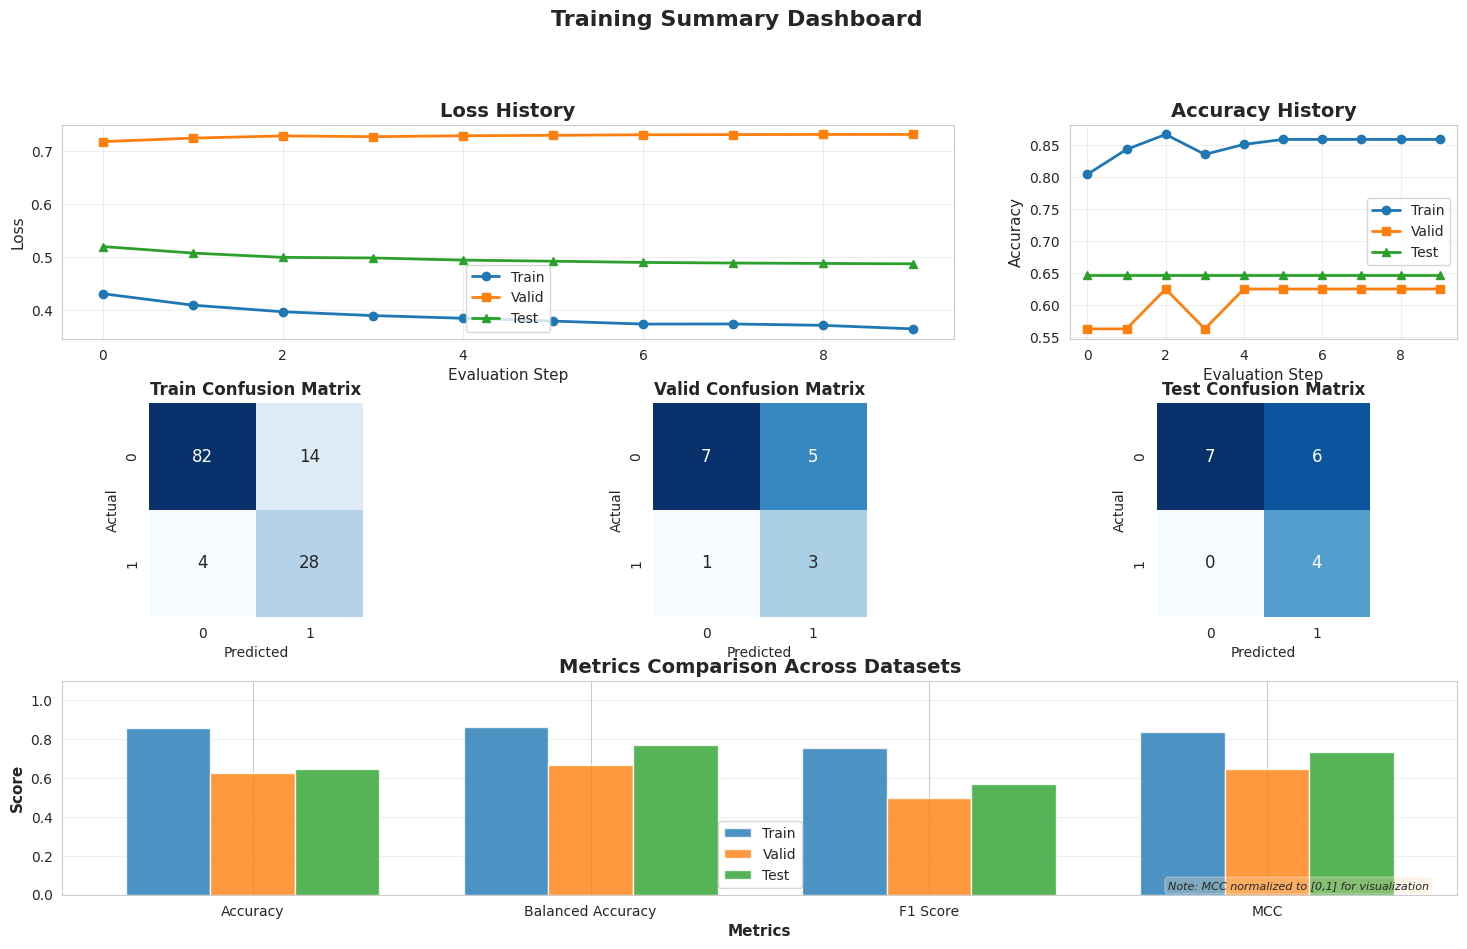


                         TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     1.0000    0.5385    0.7000        13
     Class 1     0.4000    1.0000    0.5714         4

    accuracy                         0.6471        17
   macro avg     0.7000    0.7692    0.6357        17
weighted avg     0.8588    0.6471    0.6697        17




In [19]:
mf.summarize_training(*results)

### Save Model

In [ ]:
torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [ ]:
net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

/tmp/ipykernel_34441/3766833804.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(config["PATH_TO_SAVE_MODEL"])


EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=320, out_fe

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



All possbile embedding given current model architecrure:
class_head_embs_input_features: (128, 320)
precomputed_embs: (128, 320)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_input_features with shape (128, 320)...


Computing UMAP for precomputed_embs with shape (128, 320)...

Plotting UMAP embeddings...



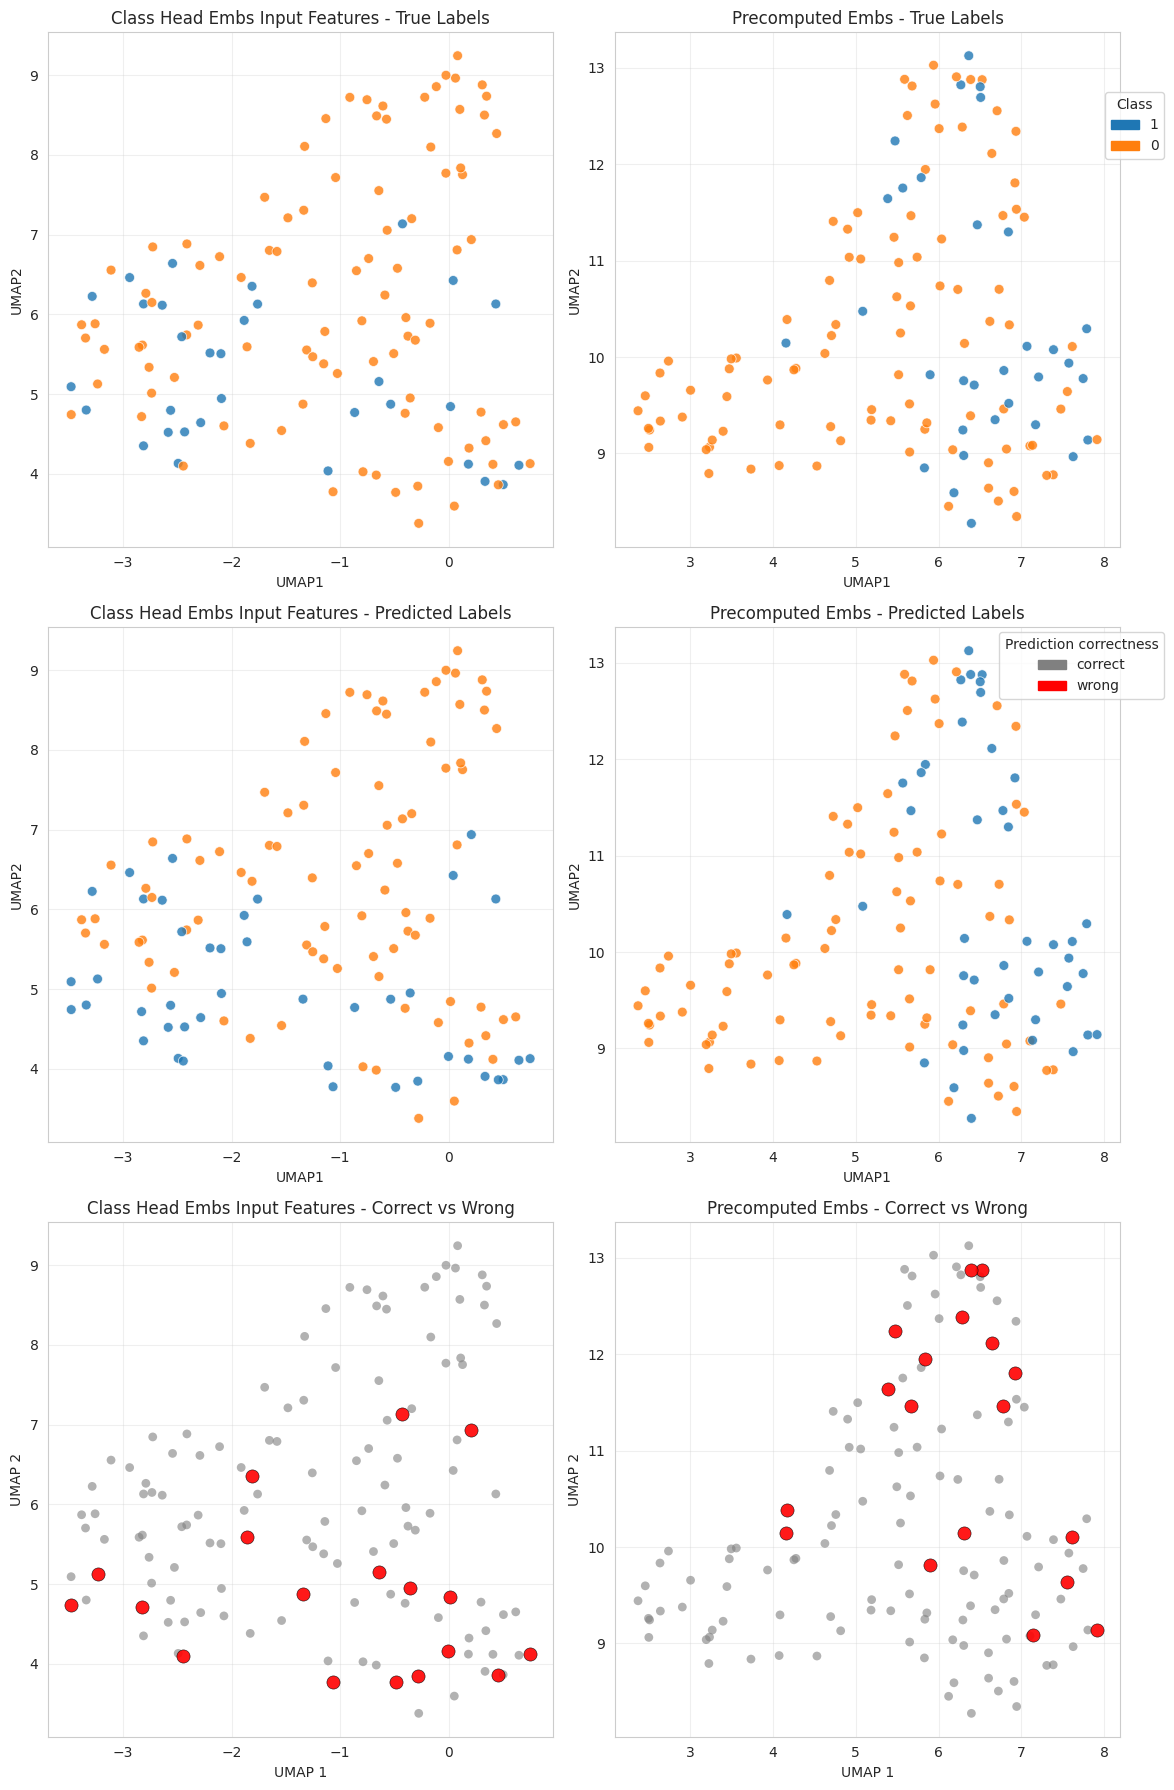

In [20]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions)
else:
    print("No embs to plot")


Extracting embeddings from training set...



All possbile embedding given current model architecrure:
class_head_embs_input_features: (539, 640)
precomputed_embs: (539, 640)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_input_features with shape (539, 640)...


Computing UMAP for precomputed_embs with shape (539, 640)...

Plotting UMAP embeddings...



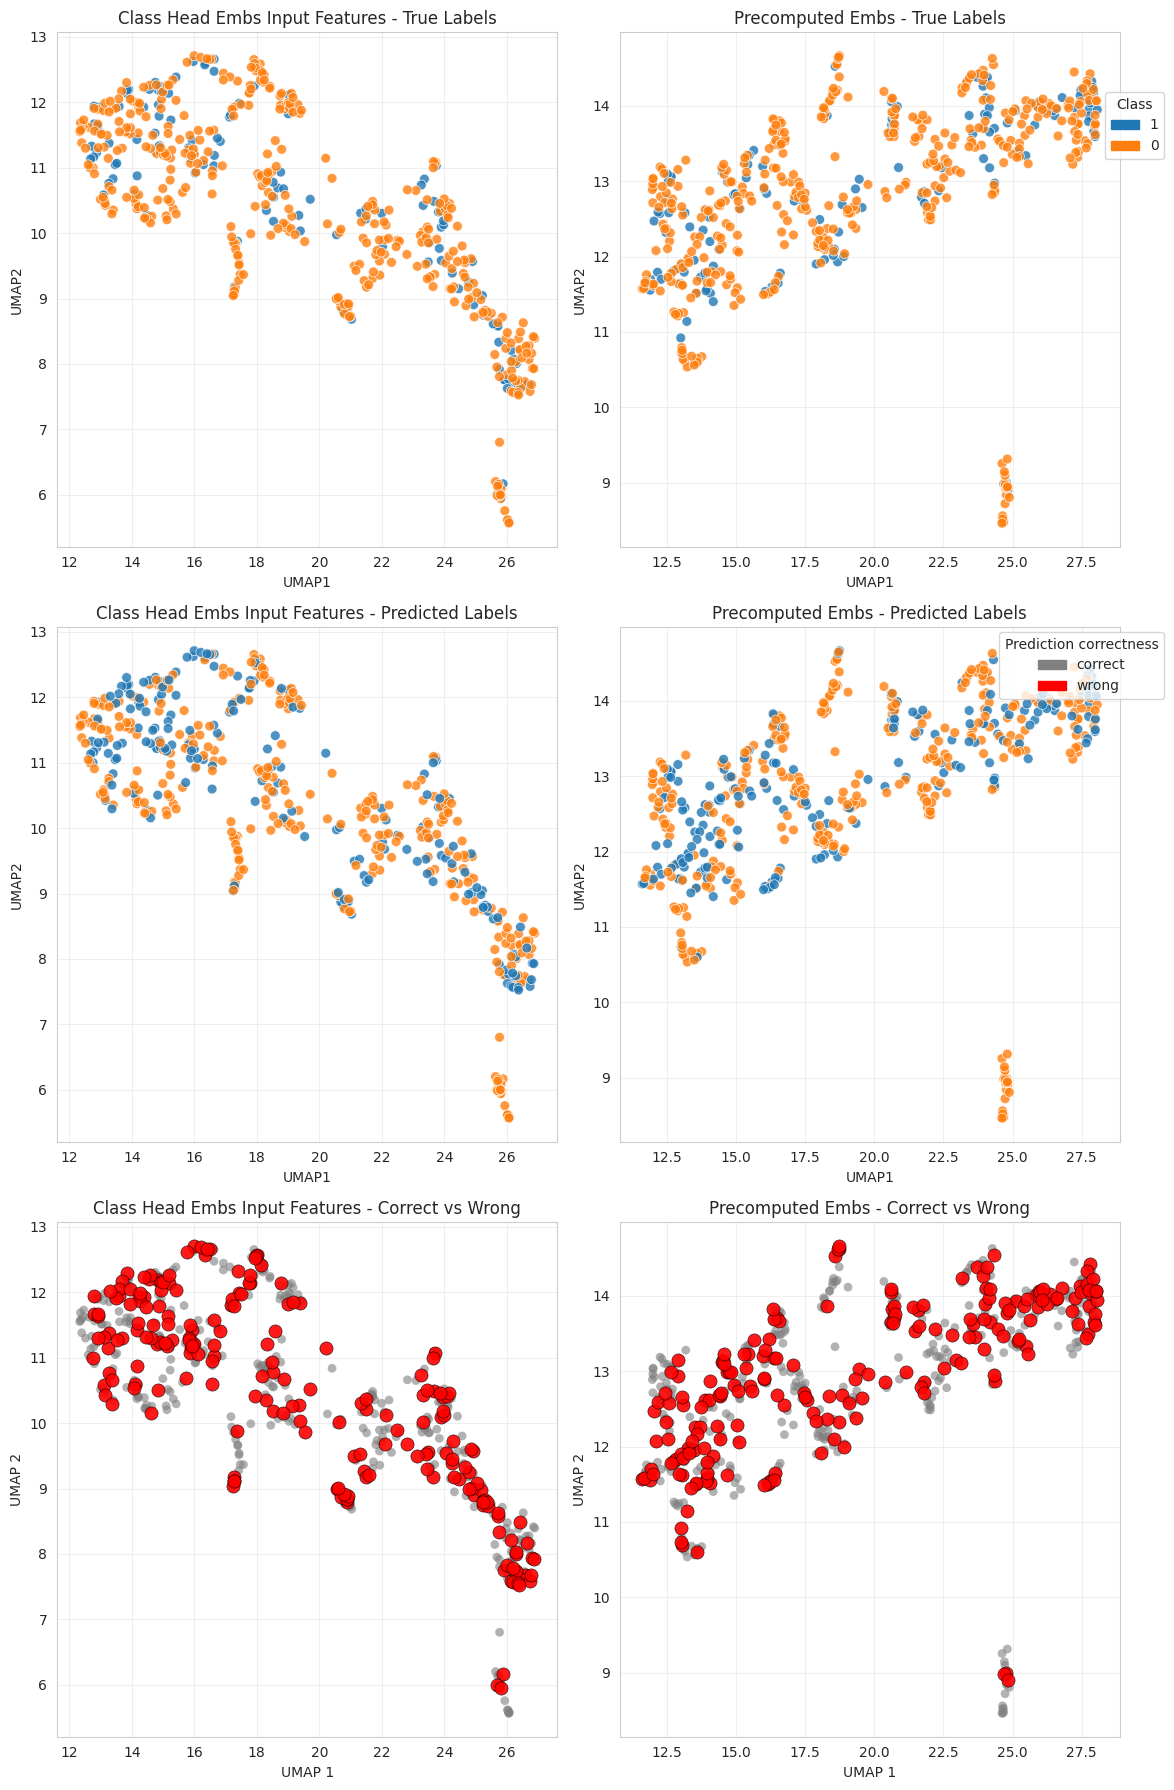

In [ ]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(umap_tensors, names, labels, predictions)
else:
    print("No embs to plot")

In [ ]:
df = df["esm_mean"]
df[(df["CorrectStr"] == "correct") & (df["TrueClass"] == "1")]

#df[df['CorrectStr'] == 'correct']


KeyError: 'esm_mean'

### A-scanning

sequence                    MSSMWSEYTIGGVKIYFPYKAYPSQLAMMNSILRGLNSKQHCLLES...
trunc_sequence              MSSMWSEYTIGGVKIYFPYKAYPSQLAMMNSILRGLNSKQHCLLES...
input_ids                   [tensor(0), tensor(20), tensor(8), tensor(8), ...
attention_mask              [tensor(1), tensor(1), tensor(1), tensor(1), t...
label                                                                       1
protein                                                                J3QKX0
sequence_length                                                           852
trunc_sequence_length                                                     852
inputs_ids_length                                                        1000
inputs_ids_length_no_pad                                                  854
set                                                                      test
Name: 41, dtype: object

5


Evaluation:   0%|          | 0/1 [00:00<?, ? Single protein batch/s]

Generating mutations:   0%|          | 0/852 [00:00<?, ?it/s]

Preprocessing mutations:   0%|          | 0/3408 [00:00<?, ?it/s]

Evaluating model on mutated sequences...


Evaluation:   0%|          | 0/101 [00:00<?, ? Multi-AA Scan batch/s]

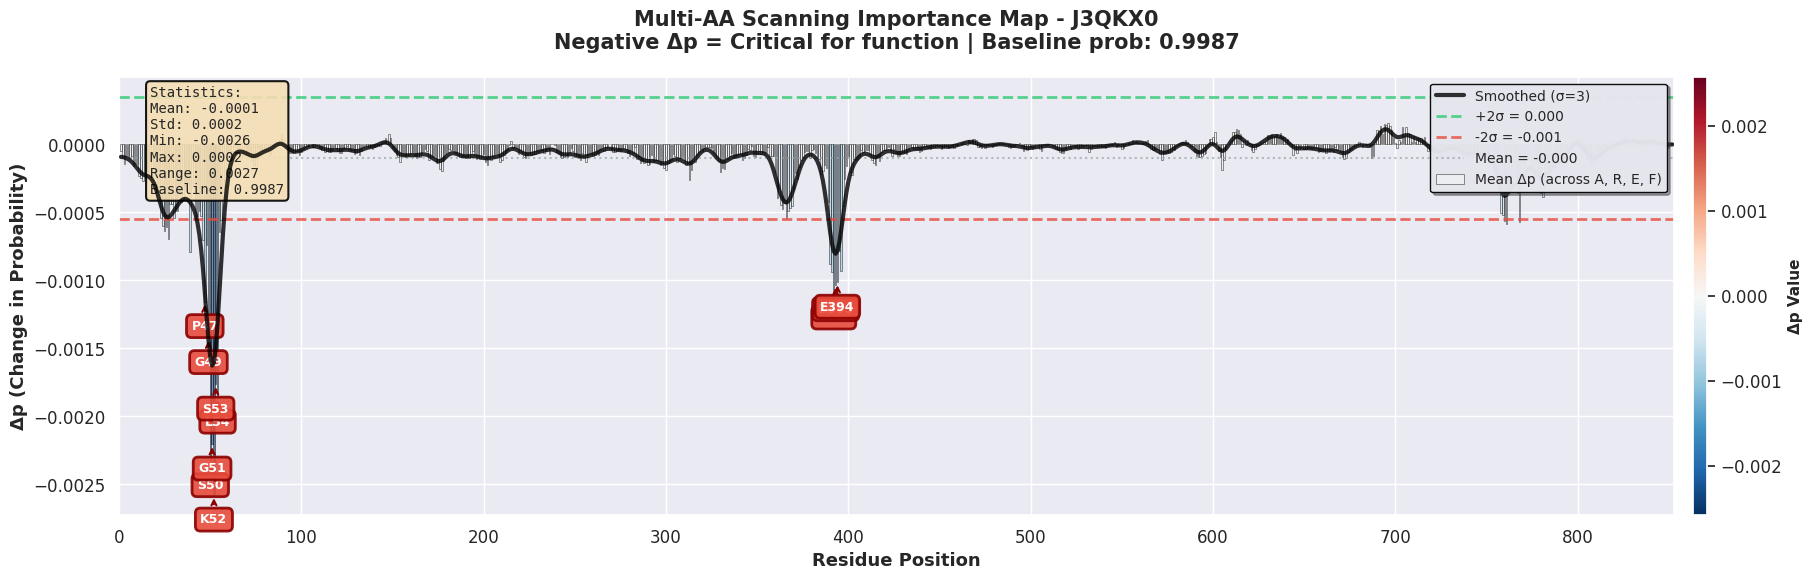


                      MULTI-AA SCANNING SUMMARY                       

Sequence Information:         
  Length:                   852
  Protein:                  J3QKX0
  Substitute AAs:           A, R, E, F
  Baseline Probability:     0.9987

Statistical Summary:          
  Mean Δp:                  -0.0001
  Std Δp:                   0.0002
  Min Δp:                   -0.0026
  Max Δp:                   0.0002
  Threshold (+2σ):          0.0004
  Threshold (-2σ):          -0.0005

──────────────────────────────────────────────────────────────────────
             TOP CRITICAL RESIDUES (Largest Negative Δp)              
──────────────────────────────────────────────────────────────────────
Rank    Position    Residue     Δp             Status              
──────────────────────────────────────────────────────────────────────
1       52          K           -0.0026        ⚠️  Beyond threshold
2       50          S           -0.0023        ⚠️  Beyond threshold
3       51          G

In [ ]:
PROTEIN = df[(df["CorrectStr"] == "correct") & (df["TrueClass"] == "1")].iloc[0].Name
#"A0A8V8TKW5" #"P39039" # "Q91VU0"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = processed_df[processed_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = 5 #int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

scan_results = mf.multi_aa_scanning(net, tokenizer, 
                      single_protein_info, 
                      window_size=WINDOW_SIZE_SUBSTITUION, 
                      substitute_aas=["A", "R", "E", "F"],
                      normalise_true_substitution=False,
                      device=config["DEVICE"])

mf.plot_multi_aa_scan(scan_results, show_per_aa=False)

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

In [ ]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = processed_df[processed_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_processed_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_processed_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_processed_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_processed_df.head(5))
#print(random_processed_df.loc[0, "input_ids"])

In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()
